## Unite all data

In [8]:
import pandas as pd
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import nltk
import multiprocessing
from sklearn.metrics import accuracy_score, f1_score

cores = multiprocessing.cpu_count()

positives=pd.read_csv('Data/positive_combined_withreal.csv')
cases=pd.read_csv('Data/case_files.csv')

positives['class']=positives['class'].str.replace(' ','')
cases_clean=pd.DataFrame(data={'class':cases['Case Type'],'complain':cases['Case Summary']})

df=pd.concat([positives,cases_clean], axis= 0,ignore_index=True)
df['class']=df['class'].apply(lambda x: x[0].upper()+x[1:])
df['class'].unique()

array(['Notrelated', 'Labor', 'Adult', 'Minor'], dtype=object)

## Text preprocessing

In [5]:
nltk.download('punkt')
from nltk.corpus import stopwords
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

[nltk_data] Downloading package punkt to /Users/maria/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [9]:
pd.set_option('display.max_colwidth', -1)
df=df.applymap(lambda x: re.sub("[^a-zA-Z0-9 ]",'',str(x)))
df['complain']=df['complain'].apply(lambda x: re.sub('notrelated|nannan','',x))
df=df.sample(frac=1) #randomize our groups

In [10]:
df[df['class']=='Notrelated'].head(10)

,class,complain
102,Notrelated,Create a rotating on call schedule dont keep wages secret and push your hard workers for raises
15,Notrelated,minimal financial incentives for exceptional performance
89,Notrelated,Physically hard and long hours
152,Notrelated,Hectic work schedule strict office clockin timings late night and weekend working expected during commercialization comparatively low pay
93,Notrelated,We are being outpaced by our value and premium competitors in the category which has put a strain on our businesses and resulted in a complete restructure of how we find value in our organization While this is an exciting challenge to overcome it is a challenge nonetheless and company culture and morale are low as a result of cost cutting layoffs and burn out being overworked Senior management is not as visible as they should be in rallying the troops to help boost positivitynan
258,Notrelated,1 Expect to fight tooth and nail for the pay andor the promotion that you deserve especially if you arent into playing dirty to get what you want 2 They arent the most well versed in the operational stuff like your benefits or pto time even though the company has been in business for nearly 10 years now 3 what HR 4 Upper managementHQ rewards nasty behavior
142,Notrelated,Management problems high turnover unwanted and unexpected overtime Favoritism and racial bias from Hispanic managers upon others Its a real challenge for some to relate with those from another culture than their own Everyone wants to be dealt with in a kind and respectful manner This takes a balance of empathy sternness and fairness to allnan
131,Notrelated,very disorganized Many services are just terrible The department environmental service is horrid The hospital is always dirty Dietary is also bad they always messed up the pts orders There is also a lack of communication between the interdisciplinary teams This sometimes causes pts care to be delayed and therefore stay longer then needed Medicals supplies are also always lacking
160,Notrelated,followers snitchessome lazy people some just to collect a pay check
45,Notrelated,Favoritism exists on all levels of management Incompetent management still on the job


In [11]:
df.to_csv('all_data_masha.csv')

In [12]:
train, test = train_test_split(df, test_size=0.3, random_state=42)
train_tagged = train.apply(lambda r: TaggedDocument(words=tokenize_text(r['complain']), tags=[r['class']]), axis=1)
test_tagged = test.apply(lambda r: TaggedDocument(words=tokenize_text(r['complain']), tags=[r['class']]), axis=1)


In [13]:
train_tagged.values[30]

TaggedDocument(words=['the', 'defendant', 'kidnapped', 'the', 'fourteen', 'year', 'old', 'victim', 'from', 'nc', 'he', 'then', 'threatened', 'her', 'and', 'frequently', 'beat', 'her', 'into', 'submission', 'until', 'she', 'agreed', 'to', 'engage', 'herself', 'in', 'commercial', 'sexual', 'acts', 'the', 'defendant', 'forced', 'the', 'victim', 'to', 'live', 'in', 'his', 'apartment', 'in', 'windowless', 'room', 'with', 'two', 'other', 'women', 'however', 'the', 'defendant', 'was', 'not', 'charged', 'for', 'harboring', 'the', 'two', 'adults', 'who', 'were', 'also', 'engaged', 'in', 'commercial', 'sexual', 'activities'], tags=['Adult'])

## Training the model

In [14]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in train_tagged.values])

In [15]:
model_dbow.train(train_tagged.values, total_examples=len(train_tagged.values),epochs=30)

In [16]:
 def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [17]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

In [18]:
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [19]:
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))


Testing accuracy 0.6666666666666666
Testing F1 score: 0.6594428886636987


## Test from differen source

https://www.theguardian.com/global-development/2017/jul/29/slept-floor-flat-near-harrods-stories-modern-slavery

In [20]:
text1='When my husband became very sick and couldn’t work, I used an employment agency to find me work abroad. I was sent to Qatar, but the family were cheating me, paying me less than agreed in my contract and refusing to give me a day off. I called the agency in the Philippines for help, but they never answered. I had to send money back home to pay for food, school fees and medicine. I fought with my employer about my salary, but he would say Your contract is just a piece of paper'

text2='I worked 12-hour shifts and finished every day at 6pm, the same time that the gang curfew in our city came into effect. There are two main gangs in the area, and anyone on the streets after the curfew becomes a target. Every day I thought might be my last. One evening, my co-worker and I were walking to the bus stop when three gang members stopped and said we’d have to sell sex and drugs for them. “We’re not asking you,” they said. “We’re giving you an order.” They let us go, but I was terrified. The next night after work, they were there, waiting for us. “Time’s up,” they said, and they forced us into a car at gunpoint'

text3='One of my friends in the village said he and a few others were leaving to find work.\
    The next day we all got a taxi and headed for Thailand. We were met by a man who said we could\
    work on his cassava farm, earning $130 (£99) a month each, \
    with room and board included. We worked seven days a week, \
    morning until night, for a month, until one evening a Thai man asked how much we were earning. He offered us $200 a month to work on a construction site, but said we’d have to move to Thailand We were confused. Weren’t we already in Thailand? It turned out we were still in Cambodia, and the farmer had already fled without giving us any wages. We were left with no choice but to accept the deal and smuggle ourselves over the border. The man said we’d be charged for being driven to the construction site, but that it could be deducted from our first month’s wages. It was a long, uncomfortable drive in a pickup, and when we finally stopped, we saw that we weren’t at a construction site, but a busy sea port. The broker said the building site had closed, so he’d arranged for us to work on a fishing boat instead'


In [106]:
import seaborn as sns
import matplotlib as mpl
sns.set(style='whitegrid')
sns.set(font_scale = 1.8,)
labels=sorted(df['class'].unique())
COLOR = 'white'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR


def check_independent(text,anme):
    text=re.sub("[^a-zA-Z0-9 ]",'',str(text))
    words=tokenize_text(text)
    regg=model_dbow_all.infer_vector(words, steps=20)
    print(logreg_all.predict([regg]))
    print(logreg_all.predict_proba([regg]))
    df_toplot=pd.DataFrame(data={'labels':labels,'values':logreg_all.predict_proba([regg])[0]})
    print(df_toplot.head())
    ax=sns.barplot(x='labels',y='values',data=df_toplot,palette='cool')
    ax.set_ylabel('Probabilities',fontsize=23,x=0)
    ax.set_xlabel('')
    ax.set_ylim([0,1])
    plt.tight_layout()
    plt.savefig('%s.png'%anme,dpi=300, transparent=True)
    

['Labor']
[[1.25607648e-02 9.87433802e-01 5.43314369e-06 1.31355066e-15]]
       labels        values
0  Adult       1.256076e-02
1  Labor       9.874338e-01
2  Minor       5.433144e-06
3  Notrelated  1.313551e-15


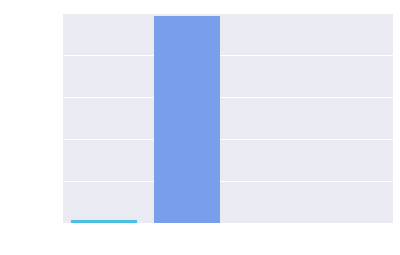

In [107]:
check_independent(text3,'text3')

['Labor']
[[1.61484715e-01 8.30754466e-01 1.13090526e-07 7.76070578e-03]]
       labels        values
0  Adult       1.614847e-01
1  Labor       8.307545e-01
2  Minor       1.130905e-07
3  Notrelated  7.760706e-03


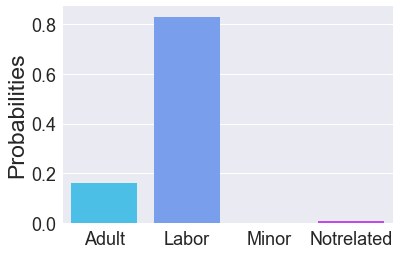

In [94]:
check_independent(text1,'text1')

['Notrelated']
[[0.00471975 0.00749851 0.00784279 0.97993895]]
       labels    values
0  Adult       0.004720
1  Labor       0.007499
2  Minor       0.007843
3  Notrelated  0.979939


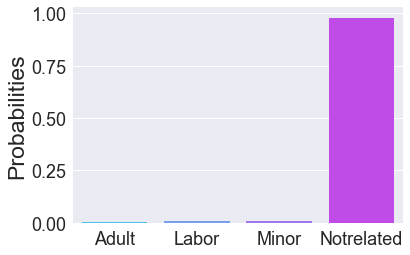

In [95]:
check_independent(text2,'text2')

['Notrelated']
[[0.00173283 0.00811754 0.00227433 0.9878753 ]]
       labels    values
0  Adult       0.001733
1  Labor       0.008118
2  Minor       0.002274
3  Notrelated  0.987875


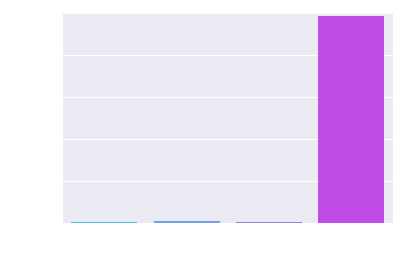

In [108]:
text0 = 'I like sex with people and also being slave'

check_independent(text2,'text0')

In [ ]:
import pickle

pickle.dump([model_dbow,logreg],open('word2vecworking2.pickle','wb'))

In [39]:
all_tagged = df.apply(lambda r: TaggedDocument(words=tokenize_text(r['complain']), tags=[r['class']]), axis=1)
model_dbow_all = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow_all.build_vocab([x for x in all_tagged.values])
model_dbow_all.train(train_tagged.values, total_examples=len(train_tagged.values),epochs=30)
y_all, X_all = vec_for_learning(model_dbow_all, train_tagged)
logreg_all = LogisticRegression(n_jobs=1, C=1e5)
logreg_all.fit(X_all, y_all)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [52]:
labels=df['class'].unique()
sorted(labels)

['Adult', 'Labor', 'Minor', 'Notrelated']